In [1]:
# Combined TSP Script with Helper Functions and Main Function

# ------------------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------------------
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import time

# For displaying animations in Jupyter Notebook
from IPython.display import Image, display

# ------------------------------------------------------------
# Helper Functions
# ------------------------------------------------------------

# Function to calculate Euclidean distance
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Function to calculate total distance of a cycle using precomputed distances
def total_cycle_distance(cycle, distance_matrix):
    distance = 0.0
    for i in range(len(cycle)):
        distance += distance_matrix[cycle[i]][cycle[(i + 1) % len(cycle)]]
    return distance

# Function to normalize a cycle for consistent comparison
def normalize_cycle(cycle):
    """
    Normalize the cycle by choosing the lexicographically smallest representation
    considering all rotations and reflections.
    """
    n = len(cycle)
    cyclic_shifts = [tuple(cycle[i:] + cycle[:i]) for i in range(n)]
    reversed_cycle = list(reversed(cycle))
    cyclic_shifts += [tuple(reversed_cycle[i:] + reversed_cycle[:i]) for i in range(n)]
    return min(cyclic_shifts)

# *** Modified Function with Lookahead ***
def build_cycle_least_distance_updated(start_edge, remaining_points, distance_matrix):
    """
    Build a cycle starting from a given edge, inserting remaining points to minimize total distance.
    No pruning based on partial cycles is applied.
    """
    cycle = list(start_edge)
    steps = [cycle.copy()]  # Record initial edge

    while remaining_points:
        best_r = None
        best_insertion_position = None
        best_total_distance = float('inf')

        # Iterate over each remaining point r
        for r in remaining_points:
            # Iterate over each possible insertion position for r
            for i in range(len(cycle)):
                p = cycle[i]
                q = cycle[(i + 1) % len(cycle)]

                # Simulate inserting r between p and q
                temp_cycle = cycle.copy()
                temp_cycle.insert(i + 1, r)
                temp_remaining = remaining_points.copy()
                temp_remaining.remove(r)

                # Continue inserting the rest of the points using incremental heuristic
                simulated_cycle, _ = build_cycle_incremental(temp_cycle, temp_remaining.copy(), distance_matrix)

                # Calculate total distance of the simulated cycle
                simulated_distance = total_cycle_distance(simulated_cycle, distance_matrix)

                # Update if this is the best (smallest) total distance found so far
                if simulated_distance < best_total_distance:
                    best_total_distance = simulated_distance
                    best_r = r
                    best_insertion_position = i + 1

        if best_r is not None:
            # Insert the best r into the cycle at the best position
            cycle.insert(best_insertion_position, best_r)
            remaining_points.remove(best_r)
            steps.append(cycle.copy())  # Record the new state of the cycle
        else:
            # If no suitable point found, break to avoid infinite loop
            break

    return cycle, steps

# Helper Function: Incremental Insertion without Lookahead
def build_cycle_incremental(current_cycle, remaining_points, distance_matrix):
    """
    Incrementally build a cycle by inserting remaining points to minimize incremental distance.
    No pruning based on partial cycles is applied.
    """
    cycle = list(current_cycle)
    steps = [cycle.copy()]

    while remaining_points:
        best_r = None
        best_insertion_position = None
        best_delta_distance = float('inf')

        # Iterate over each remaining point r
        for r in remaining_points:
            # Find the best insertion position for r based on delta distance
            for i in range(len(cycle)):
                p = cycle[i]
                q = cycle[(i + 1) % len(cycle)]

                # Calculate the incremental distance
                delta = (distance_matrix[p][r] + distance_matrix[r][q])

                # Update if this is the best (smallest) delta found so far
                if delta < best_delta_distance:
                    best_delta_distance = delta
                    best_r = r
                    best_insertion_position = i + 1

        if best_r is not None:
            # Insert the best r into the cycle at the best position
            cycle.insert(best_insertion_position, best_r)
            remaining_points.remove(best_r)
            steps.append(cycle.copy())  # Record the new state of the cycle
        else:
            # If no suitable point found, break to avoid infinite loop
            break

    return cycle, steps

# Function to process a single edge (Not used in the main script but included for completeness)
def process_edge(args):
    edge, n, distance_matrix = args
    remaining = set(range(n)) - set(edge)
    cycle, steps = build_cycle_least_distance_updated(edge, remaining.copy(), distance_matrix)

    # Ensure the cycle includes all points
    if len(cycle) == n:
        distance = total_cycle_distance(cycle, distance_matrix)
        return (distance, cycle, steps)
    else:
        return None  # No complete cycle found

# ------------------------------------------------------------
# Main Function
# ------------------------------------------------------------

def main(n=16
         , seed=42):  # Default seed=42+104=146
    """
    Main function to execute the TSP algorithm.
    
    Parameters:
    - n (int): Number of points.
    - seed (int): Seed for reproducibility.
    
    Example:
    >>> main(n=16, seed=1234)
    """
    # Adjust the default seed based on your original script
    seed = seed  # You can set seed=42+104=146 by default, or allow passing any seed
    
    print(f"Running TSP Algorithm with n={n} and seed={seed}...")
    
    # Set the seed
    np.random.seed(seed)
    
    # Generate random 2D points
    points = np.random.rand(n, 2)
    
    # Precompute all pairwise distances
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance(points[i], points[j])
            else:
                distance_matrix[i][j] = 0.0
    
    # Initialize variables to track the best cycle
    best_cycle = None
    best_distance = float('inf')
    best_steps = []  # To record the building steps of the best cycle
    
    # ------------------------------------------------------------
    # Optimization: Initialize with All Possible Edges Without Fixing Start
    # ------------------------------------------------------------
    
    # Generate all possible edges (combinations of 2 distinct points)
    edges = list(itertools.combinations(range(n), 2))
    print(f"Total number of edges to process: {len(edges)}")
    
    start_time = time.time()
    
    # Process edges sequentially
    for idx, edge in enumerate(edges):
        # Print progress
        if (idx + 1) % 10 == 0 or (idx + 1) == len(edges):
            print(f"Processing edge {idx + 1}/{len(edges)}")
    
        remaining = set(range(n)) - set(edge)
        cycle, steps = build_cycle_least_distance_updated(edge, remaining.copy(), distance_matrix)
    
        # Ensure the cycle includes all points
        if len(cycle) == n:
            distance = total_cycle_distance(cycle, distance_matrix)
    
            # Update the best cycle if a shorter distance is found
            if distance < best_distance:
                best_distance = distance
                best_cycle = cycle
                best_steps = steps.copy()  # Record the steps for the best cycle
    
    end_time = time.time()
    print(f"\nTotal computation time: {end_time - start_time:.2f} seconds")
    
    # Display the best cycle and its total distance
    if best_cycle is not None:
        print("\nBest Cycle (Modified Algorithm with Lookahead and Skipping):")
        print(best_cycle)
        print(f"Total Distance: {best_distance:.4f}")
    else:
        print("\nNo complete cycle was found.")
    
    # ------------------------------------------------------------
    # Function to Create Animation Frames
    # ------------------------------------------------------------
    def create_animation(steps, points, filename='cycle_building_least_distance_updated.gif'):
        fig, ax = plt.subplots(figsize=(8, 8))  # Set equal aspect ratio
        ax.set_title("Building the Best Cycle Step-by-Step")
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")
        ax.grid(True)
        ax.set_aspect('equal')  # Ensure equal scaling for x and y axes
    
        # Scatter plot of all points
        ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
        # Annotate points
        for idx, (x, y) in enumerate(points):
            ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)
    
        line, = ax.plot([], [], 'o-', color='red', markersize=8, zorder=1)
    
        def init():
            line.set_data([], [])
            return line,
    
        def animate(i):
            current_cycle = steps[i]
            cycle_points = points[list(current_cycle) + [current_cycle[0]]]  # Close the cycle
            line.set_data(cycle_points[:, 0], cycle_points[:, 1])
            ax.set_title(f"Step {i}: Building the Cycle")
            return line,
    
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(steps), interval=1000, blit=True)
    
        # Save the animation as a GIF
        ani.save(filename, writer='pillow')
        plt.close()
        print(f"Animation saved as {filename}")
    
    # Create and save the animation for the best cycle
    if best_cycle is not None and best_steps:
        create_animation(best_steps, points, filename='cycle_building_least_distance_updated.gif')
    
        # Display the GIF in the notebook
        display(Image(filename='cycle_building_least_distance_updated.gif'))
    else:
        print("No complete cycle was found to create an animation.")
    
    # ------------------------------------------------------------
    # Compare with OR-Tools TSP Solver
    # ------------------------------------------------------------
    
    # Function to create distance matrix for OR-Tools (integer distances)
    def create_ortools_distance_matrix(points, precomputed_distance_matrix):
        size = len(points)
        ortools_dm = []
        for i in range(size):
            row = []
            for j in range(size):
                if i == j:
                    row.append(0)
                else:
                    # Multiply by 1000 and convert to integer for OR-Tools
                    row.append(int(precomputed_distance_matrix[i][j] * 1000))
            ortools_dm.append(row)
        return ortools_dm
    
    # Create OR-Tools distance matrix by passing the precomputed distance_matrix
    ortools_distance_matrix = create_ortools_distance_matrix(points, distance_matrix)
    
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(ortools_distance_matrix), 1, 0)  # 1 vehicle, starting at node 0
    
    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)
    
    # Create and register a transit callback
    def distance_callback(from_index, to_index):
        # Returns the distance between the two nodes.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return ortools_distance_matrix[from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Add a dimension to force the route to start and end at the same location
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        100000000,  # maximum distance
        True,  # start cumul to zero
        'Distance'
    )
    
    # Setting first solution heuristic (cheapest addition)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    
    # Function to extract the route from the solution
    def get_route(solution, routing, manager):
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        return route
    
    # Extract the OR-Tools TSP solution
    if solution:
        ortools_route = get_route(solution, routing, manager)
    
        # Recompute the total distance using exact float distances
        ortools_distance = 0.0
        for i in range(len(ortools_route)):
            from_node = ortools_route[i]
            to_node = ortools_route[(i + 1) % len(ortools_route)]
            ortools_distance += distance_matrix[from_node][to_node]
    
        print("\nOR-Tools TSP Solution:")
        print(ortools_route)
        print(f"Total Distance: {ortools_distance:.4f}")
    else:
        print("\nNo solution found by OR-Tools.")
    
    # ------------------------------------------------------------
    # Comparison and Visualization
    # ------------------------------------------------------------
    
    # Function to check if two cycles are the same (ignoring starting point and direction)
    def cycles_are_same(cycle1, cycle2):
        if len(cycle1) != len(cycle2):
            return False
        n = len(cycle1)
        try:
            start_index = cycle2.index(cycle1[0])
        except ValueError:
            return False
        # Check both possible directions
        for direction in [1, -1]:
            match = True
            for i in range(n):
                if cycle1[i] != cycle2[(start_index + direction * i) % n]:
                    match = False
                    break
            if match:
                return True
        return False
    
    # Check if the cycles are the same
    if solution and best_cycle is not None:
        same_cycles = cycles_are_same(best_cycle, ortools_route)
        print(f"\nAre the Custom Algorithm and OR-Tools cycles the same? {'Yes' if same_cycles else 'No'}")
    else:
        same_cycles = False
        print("\nCannot determine cycle equality as no solution was found by OR-Tools or no complete cycle was built.")
    
    # Function to plot both cycles with equal aspect ratio
    def plot_comparison(custom_cycle, ortools_cycle, points, custom_distance, ortools_distance):
        fig, ax = plt.subplots(figsize=(8, 8))  # Set square figure size
        ax.set_title("Comparison of Custom Algorithm and OR-Tools TSP Solution")
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")
        ax.grid(True)
        ax.set_aspect('equal')  # Ensure equal scaling for x and y axes
    
        # Determine plot limits
        margin = 0.05  # Add some margin around the points
        x_min, x_max = points[:, 0].min() - margin, points[:, 0].max() + margin
        y_min, y_max = points[:, 1].min() - margin, points[:, 1].max() + margin
        # Make sure both axes have the same limits
        overall_min = min(x_min, y_min)
        overall_max = max(x_max, y_max)
        ax.set_xlim(overall_min, overall_max)
        ax.set_ylim(overall_min, overall_max)
    
        # Scatter plot of all points
        ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
        # Annotate points
        for idx, (x, y) in enumerate(points):
            ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)
    
        # Plot Custom Cycle
        custom_cycle_points = points[list(custom_cycle) + [custom_cycle[0]]]
        ax.plot(custom_cycle_points[:, 0], custom_cycle_points[:, 1], 'o-', color='red', label=f'Custom Cycle ({custom_distance:.4f})', markersize=8)
    
        # Plot OR-Tools Cycle
        ortools_cycle_points = points[ortools_route + [ortools_route[0]]]
        ax.plot(ortools_cycle_points[:, 0], ortools_cycle_points[:, 1], 'o--', color='green', label=f'OR-Tools TSP ({ortools_distance:.4f})', markersize=8)
    
        ax.legend()
        plt.show()
    
    # Plot comparison if OR-Tools solution exists
    if solution and best_cycle is not None:
        plot_comparison(best_cycle, ortools_route, points, best_distance, ortools_distance)
    
        # Print comparison
        print("\nComparison:")
        print(f"Custom Algorithm Total Distance: {best_distance:.4f}")
        print(f"OR-Tools TSP Total Distance: {ortools_distance:.4f}")
        improvement = ((best_distance - ortools_distance) / ortools_distance) * 100
        print(f"Improvement by OR-Tools: {improvement:.2f}%")
    else:
        print("Cannot compare with OR-Tools as no solution was found or no complete cycle was built.")


Running TSP Algorithm with n=16 and seed=1234...
Total number of edges to process: 120
Processing edge 10/120
Processing edge 20/120
Processing edge 30/120
Processing edge 40/120
Processing edge 50/120
Processing edge 60/120
Processing edge 70/120
Processing edge 80/120
Processing edge 90/120
Processing edge 100/120
Processing edge 110/120
Processing edge 120/120

Total computation time: 25.24 seconds

Best Cycle (Modified Algorithm with Lookahead and Skipping):
[0, 14, 5, 7, 10, 3, 13, 1, 6, 9, 4, 12, 15, 2, 8, 11]
Total Distance: 3.1835
Animation saved as cycle_building_least_distance_updated.gif


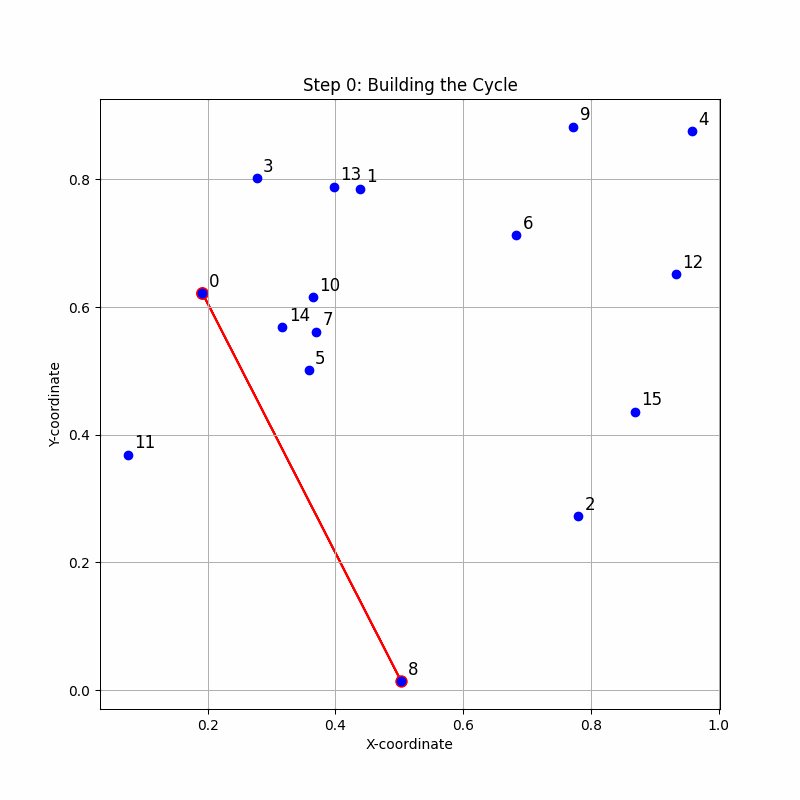


OR-Tools TSP Solution:
[0, 14, 5, 7, 10, 3, 13, 1, 6, 9, 4, 12, 15, 2, 8, 11]
Total Distance: 3.1835

Are the Custom Algorithm and OR-Tools cycles the same? Yes


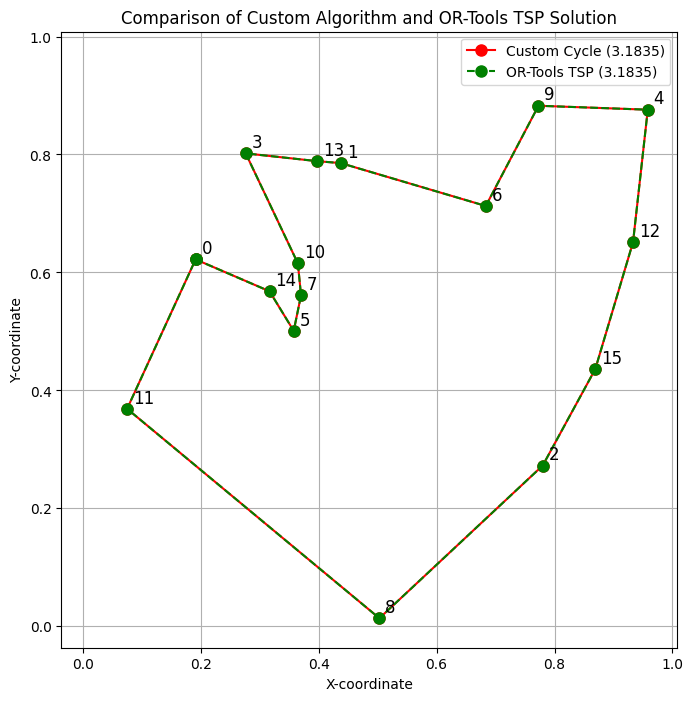


Comparison:
Custom Algorithm Total Distance: 3.1835
OR-Tools TSP Total Distance: 3.1835
Improvement by OR-Tools: 0.00%


In [2]:
main(n=16, seed=1234)